# setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [5]:
from vnstock import Listing, Quote, Company, Finance, Trading, Screener 

/opt/conda/envs/quant/lib/python3.12/site-packages/vnai/scope/profile.py:562: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# load data

In [6]:
def get_symbols_by_group(group_name):
    listing = Listing()
    return listing.symbols_by_group(group_name)

def fetch_history_for_symbols(symbols, start='2010-01-01', end='2025-08-25', interval='1D'):
    all_data = []
    for symbol in symbols:
        quote = Quote(symbol=symbol, source='VCI')
        df = quote.history(start=start, end=end, interval=interval)
        df['symbol'] = symbol
        all_data.append(df)
    result = pd.concat(all_data, ignore_index=True)
    result['time'] = pd.to_datetime(result['time'])
    return result

def save_to_csv(df, filepath):
    df.to_csv(filepath, index=False)
    print(f"Đã lưu dữ liệu vào {filepath}")

def filter_data_by_symbol(symbol, df, start=None, end=None):
    df.index = pd.to_datetime(df.index)
    if start is None:
        start = df.index.min()
    if end is None:
        end = df.index.max()
    return df[(df['symbol'] == symbol) & (df.index >= start) & (df.index <= end)]

In [7]:
# Fetch VN30F1M (nearest month VN30 futures) historical data using vnstock
vn30f1m_quote = Quote(symbol='VN30F1M', source='VCI')
vn30f1m_index = vn30f1m_quote.history(start='2018-01-01', end='2025-08-25', interval='1D')
vn30f1m_index['time'] = pd.to_datetime(vn30f1m_index['time'])
vn30f1m_index = vn30f1m_index.set_index('time')
vn30f1m_index.head()

,open,high,low,close,volume
time,,,,,
2018-01-02,983.9,999.0,980.8,999.0,11347
2018-01-03,1002.5,1015.2,1002.0,1012.8,16134
2018-01-04,1014.8,1023.9,1012.8,1023.9,13815
2018-01-05,1024.1,1025.0,1007.0,1012.0,16296
2018-01-08,1008.3,1031.0,1005.7,1030.0,13326


In [8]:
# Fetch VN30 index historical data using vnstock
vn30_quote = Quote(symbol='VN30', source='VCI')
vn30_index = vn30_quote.history(start='2010-01-01', end='2025-08-25', interval='1D')
vn30_index['time'] = pd.to_datetime(vn30_index['time'])
vn30_index = vn30_index.set_index('time')
vn30_index.head()

,open,high,low,close,volume
time,,,,,
2012-02-06,447.47,447.47,447.47,447.47,13467070
2012-02-07,449.31,449.31,449.31,449.31,17261070
2012-02-08,460.98,460.98,460.98,460.98,20406280
2012-02-09,464.73,464.73,464.73,464.73,20379320
2012-02-10,458.23,458.23,458.23,458.23,20816360


In [9]:
data_all = pd.read_csv('data/vn30_history.csv')
data_all = data_all.set_index('time')
data_all.head()

,open,high,low,close,volume,symbol
time,,,,,,
2010-01-04,3.71,3.97,3.69,3.97,2765900,ACB
2010-01-05,4.06,4.14,3.94,3.97,1929200,ACB
2010-01-06,3.96,4.01,3.86,3.86,1303300,ACB
2010-01-07,3.95,3.97,3.84,3.86,1342000,ACB
2010-01-08,3.87,4.01,3.80,3.83,1461300,ACB


In [10]:
df_hpg = filter_data_by_symbol('HPG',df=data_all)
df_hpg.head()

,open,high,low,close,volume,symbol
time,,,,,,
2010-01-04,1.47,1.49,1.47,1.49,603120,HPG
2010-01-05,1.56,1.56,1.49,1.56,1203080,HPG
2010-01-06,1.55,1.61,1.54,1.61,1771660,HPG
2010-01-07,1.64,1.68,1.61,1.66,1535800,HPG
2010-01-08,1.70,1.70,1.59,1.59,909010,HPG


# macd divergence

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- EMA & MACD ----------
def ema_tv(series: pd.Series, length: int) -> pd.Series:
    s = pd.Series(series, dtype='float64').copy()
    if s.first_valid_index() is None:
        return pd.Series(np.nan, index=s.index)
    alpha = 2.0 / (length + 1.0)
    ema = np.full(len(s), np.nan)
    i0 = np.where(~np.isnan(s.values))[0][0]
    ema[i0] = s.iloc[i0]
    for i in range(i0 + 1, len(s)):
        ema[i] = alpha * s.iloc[i] + (1 - alpha) * ema[i - 1]
    return pd.Series(ema, index=s.index)

def calculate_macd(series: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = ema_tv(series, fast)
    ema_slow = ema_tv(series, slow)
    macd = ema_fast - ema_slow
    macd_signal = ema_tv(macd, signal)
    hist = macd - macd_signal
    return macd, macd_signal, hist

# ---------- Extrema Finder ----------
def find_hist_extrema(hist: pd.Series, strict_window=5, local_window=1):
    s = pd.Series(hist, dtype='float64').copy()
    peaks_strict, troughs_strict = [], []
    peaks_local, troughs_local = [], []

    for i in range(len(s)):
        # strict extrema (t1/p1) = 5 nến trước + 5 nến sau
        if i >= strict_window and i < len(s) - strict_window:
            window = s.iloc[i - strict_window:i + strict_window + 1]
            if s.iloc[i] == window.max() and s.iloc[i] > 0:
                peaks_strict.append(s.index[i])
            if s.iloc[i] == window.min() and s.iloc[i] < 0:
                troughs_strict.append(s.index[i])

        # local extrema (t2/p2) = 1 nến trước + 1 nến sau
        if i >= local_window and i < len(s) - local_window:
            window = s.iloc[i - local_window:i + local_window + 1]
            if s.iloc[i] == window.max() and s.iloc[i] > 0:
                peaks_local.append(s.index[i])
            if s.iloc[i] == window.min() and s.iloc[i] < 0:
                troughs_local.append(s.index[i])

    return {
        "peaks_strict": peaks_strict,
        "troughs_strict": troughs_strict,
        "peaks_local": peaks_local,
        "troughs_local": troughs_local
    }

# ---------- Divergence Finder ----------
def find_macd_divergence(df, fast=12, slow=26, signal=9, window=150):
    df = df.sort_index().copy()
    df['macd'], df['signal'], df['hist'] = calculate_macd(df['close'], fast, slow, signal)

    hist_ext = find_hist_extrema(df['hist'])
    bullish, bearish = [], []

    # bullish divergence: t1 strict, t2 local
    for t1 in hist_ext["troughs_strict"]:
        for t2 in hist_ext["troughs_local"]:
            if t2 <= t1: 
                continue
            if (t2 - t1).days > window: 
                continue
            if df.loc[t2, 'close'] < df.loc[t1, 'close'] and df.loc[t2, 'hist'] > df.loc[t1, 'hist']:
                bullish.append((t1, t2))

    # bearish divergence: p1 strict, p2 local
    for p1 in hist_ext["peaks_strict"]:
        for p2 in hist_ext["peaks_local"]:
            if p2 <= p1: 
                continue
            if (p2 - p1).days > window: 
                continue
            if df.loc[p2, 'close'] > df.loc[p1, 'close'] and df.loc[p2, 'hist'] < df.loc[p1, 'hist']:
                bearish.append((p1, p2))

    bull_df = pd.DataFrame(bullish, columns=['t1','t2']).set_index('t2') if bullish else pd.DataFrame(columns=['t1'])
    bear_df = pd.DataFrame(bearish, columns=['p1','p2']).set_index('p2') if bearish else pd.DataFrame(columns=['p1'])

    return bull_df, bear_df, df, hist_ext

# ---------- Visualization ----------
def visualize_divergence(df, bullish, bearish, hist_ext, annotate=True):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,10), sharex=True,
                                   gridspec_kw={'height_ratios':[2,1]})

    ax1.plot(df.index, df['close'], label='Close', color='black')
    ax2.bar(df.index, df['hist'], alpha=0.5, label='Histogram')
    ax2.plot(df.index, df['macd'], label='MACD')
    ax2.plot(df.index, df['signal'], label='Signal', linestyle='--')
    ax2.axhline(0, color='black', lw=0.7)

    # mark extrema
    ax2.scatter(hist_ext["peaks_strict"], df.loc[hist_ext["peaks_strict"], 'hist'], marker='^', color='red', s=80, label='Peak strict')
    ax2.scatter(hist_ext["troughs_strict"], df.loc[hist_ext["troughs_strict"], 'hist'], marker='v', color='green', s=80, label='Trough strict')
    ax2.scatter(hist_ext["peaks_local"], df.loc[hist_ext["peaks_local"], 'hist'], marker='^', color='orange', s=60, label='Peak local')
    ax2.scatter(hist_ext["troughs_local"], df.loc[hist_ext["troughs_local"], 'hist'], marker='v', color='blue', s=60, label='Trough local')

    # bullish
    for t2, row in bullish.iterrows():
        t1 = row['t1']
        ax1.plot([t1,t2], [df.loc[t1,'close'], df.loc[t2,'close']], color='green', lw=2)
        ax2.plot([t1,t2], [df.loc[t1,'hist'], df.loc[t2,'hist']], color='green', lw=2)
        if annotate: ax1.text(t2, df.loc[t2,'close'], 'Bull', color='green')

    # bearish
    for p2, row in bearish.iterrows():
        p1 = row['p1']
        ax1.plot([p1,p2], [df.loc[p1,'close'], df.loc[p2,'close']], color='red', lw=2)
        ax2.plot([p1,p2], [df.loc[p1,'hist'], df.loc[p2,'hist']], color='red', lw=2)
        if annotate: ax1.text(p2, df.loc[p2,'close'], 'Bear', color='red')

    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    return fig, ax1, ax2


In [28]:
# -------------------------
# Usage examples (ngắn gọn):
# -------------------------
bullish, bearish, df_res = find_macd_divergence(df_hpg, window=90)
print("Bullish t2 dates:", bullish.index.strftime("%Y-%m-%d").tolist())
print('Bearish p2 dates:', bearish.index.strftime("%Y-%m-%d").tolist())

ValueError: too many values to unpack (expected 3)

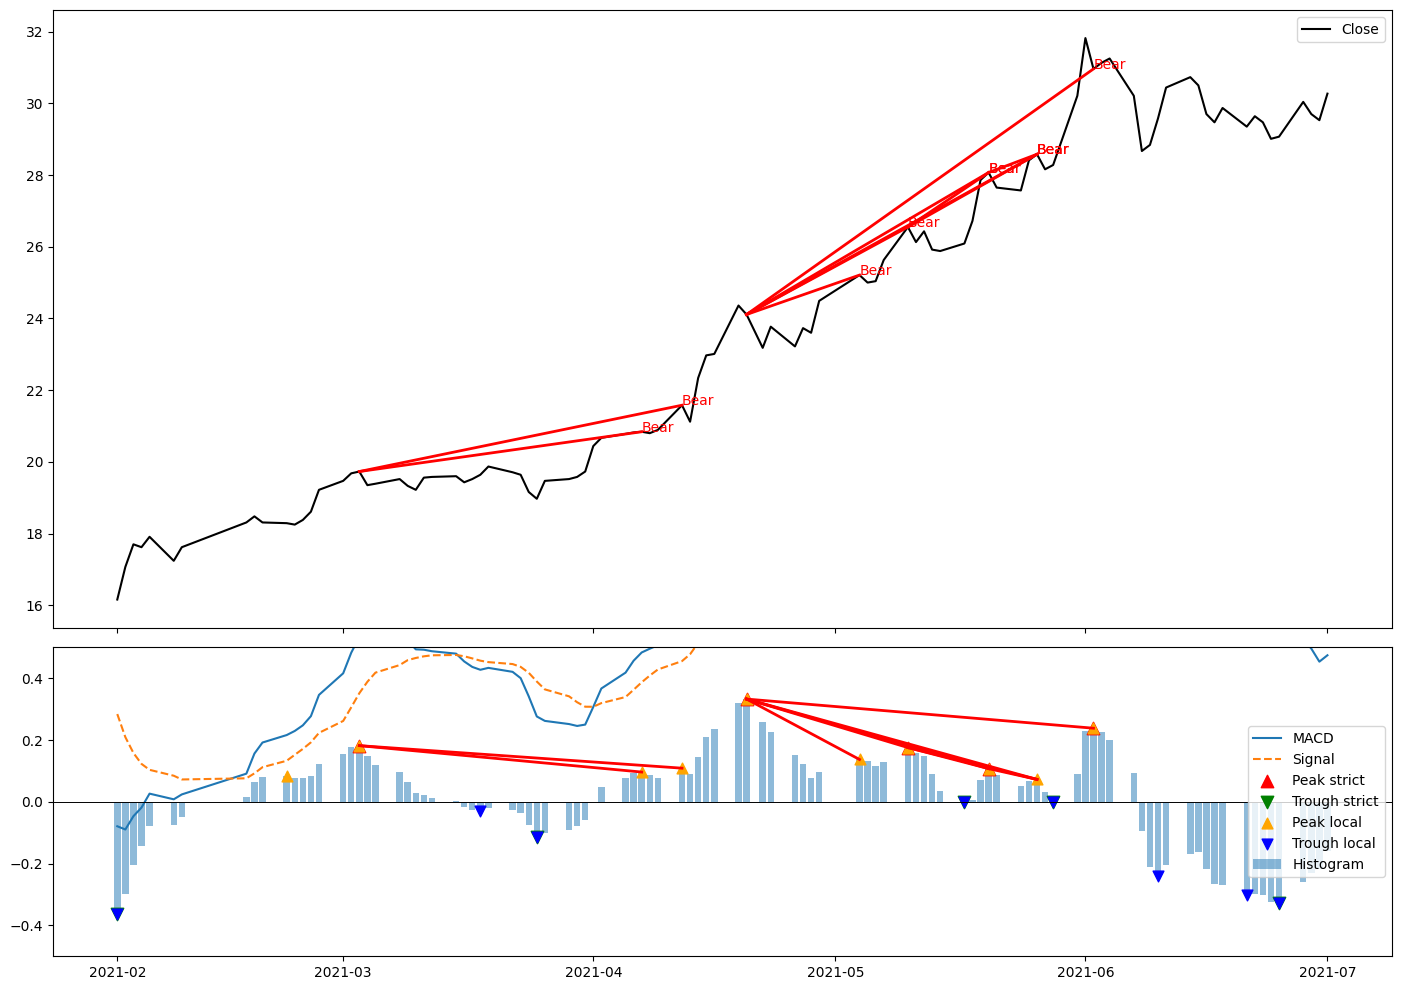

In [34]:
# ...existing code...
start_date = "2021-02-01"
end_date = "2021-07-01"

bullish, bearish, df_res, hist_ext = find_macd_divergence(df_hpg, window=50)

df_res_filtered = df_res.loc[start_date:end_date]

# Lọc bullish: cả index (t2) và t1 đều nằm trong df_res_filtered.index
bullish_filtered = bullish[
    (bullish.index >= start_date) & (bullish.index <= end_date) &
    (bullish['t1'] >= df_res_filtered.index.min()) & (bullish['t1'] <= df_res_filtered.index.max())
]

# Lọc bearish: cả index (p2) và p1 đều nằm trong df_res_filtered.index
bearish_filtered = bearish[
    (bearish.index >= start_date) & (bearish.index <= end_date) &
    (bearish['p1'] >= df_res_filtered.index.min()) & (bearish['p1'] <= df_res_filtered.index.max())
]

# ...existing code...
# Lọc hist_ext để chỉ giữ các timestamp còn trong df_res_filtered
def filter_hist_ext(hist_ext, valid_index):
    return {
        k: [x for x in v if x in valid_index]
        for k, v in hist_ext.items()
    }

hist_ext_filtered = filter_hist_ext(hist_ext, df_res_filtered.index)

fig, ax1, ax2 = visualize_divergence(df_res_filtered, bullish_filtered, bearish_filtered, hist_ext_filtered)

# ax1.set_ylim(23, 30)
ax2.set_ylim(-0.5, 0.5)

plt.show()
